In [299]:
#!/usr/bin/python3
import matplotlib.pyplot as plt
import os
import numpy as np
import matplotlib.ticker as ticker
from scipy.optimize import curve_fit

def depletionPlot(fname, location):

    os.chdir(location)
    with open(fname, 'r') as f: file = f.readlines()
    
    skip = [num for num, line in enumerate(file) if 'ALL:' in line.split()]
    iterations = np.array([int(i.split()[-1].strip()) for i in file if '#mass' in i.split()])
    length = len(iterations)

    data = np.genfromtxt(fname, skip_header = skip[0]+1)

    cycle = int(len(data)/iterations.sum())
    time = data[:,1][:cycle]

    temp, temp1, temp2, mass, counts = [], [], [], [], []
    k = 0
    for i in range(len(iterations)):
        j = iterations[i]*cycle
        mass.append(data[:,0][k])
        counts.append(data[:,2][k:k+j])
        k += j
        
        for c in range(cycle):
            for l in range(iterations[i]):
                temp.append(counts[i][(l*cycle)+c])
            temp1.append(temp)
            temp = []
        temp2.append(temp1)
        temp1 = []
        
    mean = [[np.array(temp2[i][j]).mean() for j in range(cycle)]for i in range(length)]
    error = [[(np.array(temp2[i][j]).std()/np.sqrt(iterations[i])) for j in range(cycle)]for i in range(length)]
    mass, mean, error = np.array(mass), np.array(mean), np.array(error)
    
    return mass, iterations, mean, error, time

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log
  


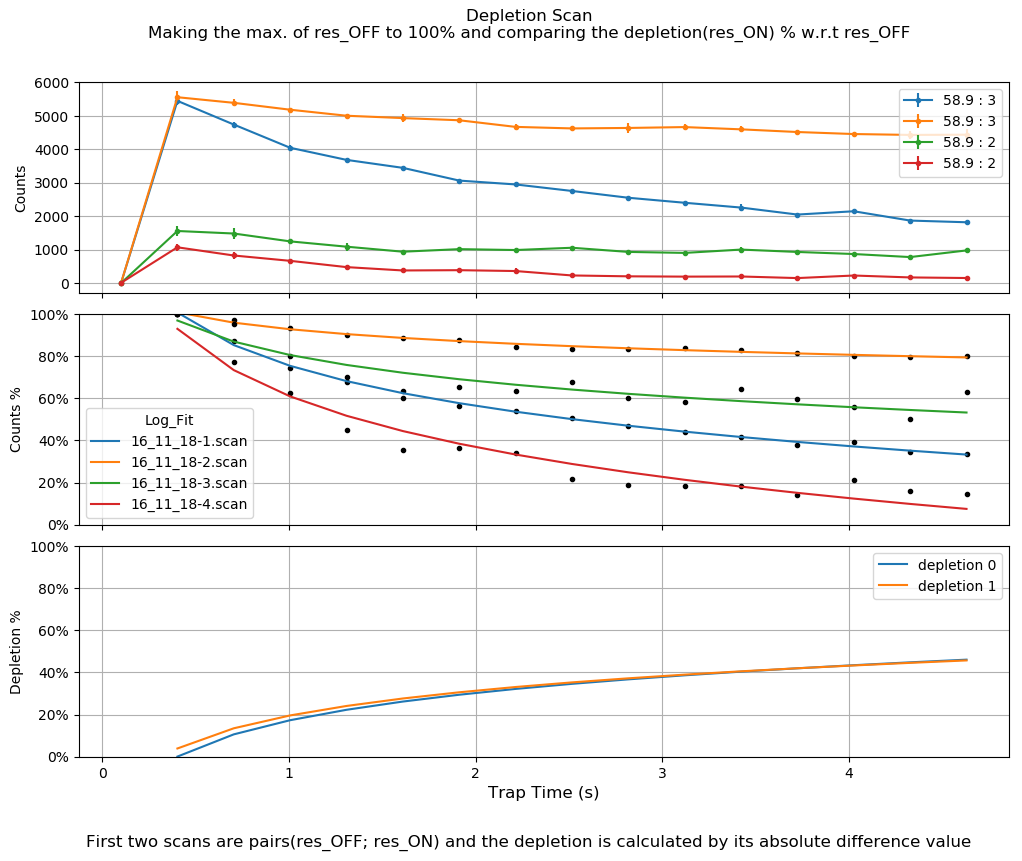

In [308]:
def func(x, a, b, c):
    return a*np.log(b*x)+c

location = 'D:\\FELion-Spectrum-Analyser\\testing\\_datas'
files = ['16_11_18-1.scan', '16_11_18-2.scan','16_11_18-3.scan', '16_11_18-4.scan']

plt.rcParams['figure.figsize']=(10,10)
plt.rcParams['figure.dpi']=100

fig, (ax1, ax2, ax3) = plt.subplots(3,1, sharex=True)
plt.suptitle('Depletion Scan\nMaking the max. of res_OFF to 100% and comparing the depletion(res_ON) % w.r.t res_OFF',\
             fontsize=12)

plt.subplots_adjust(top=0.9, hspace=0.1, bottom=0.15)

full = []
for f in files:
    
    mass, iterations, mean, error, time = depletionPlot(f, location)
    time = time/1000
    length = len(iterations)
    
    for i in range(length):
        
        lg = '%s : %s'%(mass[i], iterations[i])
        ax1.errorbar(time, mean[i],yerr=error[i], fmt='.-', label=lg)
        
        new_mean = (mean[i]/mean[i].max())*100
        
        x, y = time[1:], new_mean[1:]
        pop, popc = curve_fit(func, x, y)
        y_fit = func(x, *pop)
        
        ax2.plot(x,y,'.k')
        ax2.plot(x, y_fit, label=f)
        ax2.yaxis.set_major_formatter(ticker.PercentFormatter())
        
        full.append(y_fit)
        
depletion = {}
j=0
for i in range(0, len(full), 2):
    depletion['depletion_%s'%i]=np.absolute(full[i]-full[i+1])
    temp = np.absolute(full[i]-full[i+1])
    ax3.plot(time[1:], temp, label='depletion %s'%j)
    j+=1

ax3.yaxis.set_major_formatter(ticker.PercentFormatter())

for i in [ax1, ax2, ax3]:
    i.legend()
    i.grid(True)
    
ax2.legend(title='Log_Fit')
ax1.set_ylabel('Counts')

ax2.set_ylabel('Counts %')
ax2.set_ylim(ymin=0,ymax=100)

ax3.set_ylabel('Depletion %')
ax3.set_ylim(ymin=0,ymax=100)
ax3.set_xlabel('Trap Time (s)', fontsize=12)

#Caption
fig.text(.5, .05,\
         'First two scans are pairs(res_OFF; res_ON) and the depletion is calculated by its absolute difference value',\
         ha='center', fontsize=12)
plt.savefig('depletion.png')
plt.show()
plt.close()

In [301]:
os.getcwd()

'D:\\FELion-Spectrum-Analyser\\testing\\_datas'